# EDA On the eVED Dataset

Downloading the necessary packages

In [15]:
!pip install pandas numpy matplotlib seaborn folium scikit-learn missingno

### Package Imports

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from datetime import datetime
import folium
from folium.plugins import HeatMap
from sklearn.neighbors import KDTree
import warnings
import missingno as msno
warnings.filterwarnings('ignore')

In [19]:
# Default paths for the figures
plt.rcParams['figure.figsize'] = (14, 8)
sns.set_style('whitegrid')

# Set up path to the data
eved_folder = os.path.expanduser("~/Downloads/eVED")

In [21]:
# List all CSV files in the folder (should be stored locally in the downloads folder)
folder_path = Path(eved_folder)
csv_files = list(folder_path.glob('*.csv'))
print(f"Found {len(csv_files)} CSV files")

# Display file info
for file in csv_files:
    print(f"  - {file.name} ({file.stat().st_size / (1024*1024):.2f} MB)")

Found 54 CSV files
  - eVED_180509_week.csv (104.03 MB)
  - eVED_171213_week.csv (167.09 MB)
  - eVED_181017_week.csv (95.58 MB)
  - eVED_180718_week.csv (99.13 MB)
  - eVED_171101_week.csv (114.68 MB)
  - eVED_180117_week.csv (131.35 MB)
  - eVED_180808_week.csv (89.23 MB)
  - eVED_180502_week.csv (105.28 MB)
  - eVED_171227_week.csv (77.94 MB)
  - eVED_180307_week.csv (99.94 MB)
  - eVED_180815_week.csv (74.06 MB)
  - eVED_171122_week.csv (118.27 MB)
  - eVED_180606_week.csv (106.81 MB)
  - eVED_171129_week.csv (132.24 MB)
  - eVED_180704_week.csv (81.76 MB)
  - eVED_180411_week.csv (108.36 MB)
  - eVED_180214_week.csv (97.27 MB)
  - eVED_180221_week.csv (71.52 MB)
  - eVED_180328_week.csv (91.37 MB)
  - eVED_180425_week.csv (111.57 MB)
  - eVED_180530_week.csv (103.04 MB)
  - eVED_181010_week.csv (78.33 MB)
  - eVED_180124_week.csv (114.12 MB)
  - eVED_181024_week.csv (108.75 MB)
  - eVED_180110_week.csv (136.86 MB)
  - eVED_171220_week.csv (134.34 MB)
  - eVED_180516_week.csv (115.

In [23]:
# Load the data with sampling to manage memory
sample_size = 500000  # Adjust based on your computer's memory capacity
chunk_size = 100000
dataframes = []

for file in csv_files:
    try:
        file_size_mb = file.stat().st_size / (1024*1024)
        
        if file_size_mb > 500:
            print(f"Loading {file.name} in chunks...")
            chunks = pd.read_csv(file, chunksize=chunk_size, low_memory=False)
            df_chunks = []
            for chunk in chunks:
                if sample_size:
                    chunk = chunk.sample(min(len(chunk), sample_size//len(csv_files)))
                df_chunks.append(chunk)
            df = pd.concat(df_chunks, ignore_index=True)
        else:
            df = pd.read_csv(file, low_memory=False)
            if sample_size:
                df = df.sample(min(len(df), sample_size//len(csv_files)))
        
        df['source_file'] = file.name
        dataframes.append(df)
        print(f"Successfully loaded {file.name}")
        
    except Exception as e:
        print(f"Error loading {file}: {e}")

Successfully loaded eVED_180509_week.csv
Successfully loaded eVED_171213_week.csv
Successfully loaded eVED_181017_week.csv
Successfully loaded eVED_180718_week.csv
Successfully loaded eVED_171101_week.csv
Successfully loaded eVED_180117_week.csv
Successfully loaded eVED_180808_week.csv
Successfully loaded eVED_180502_week.csv
Successfully loaded eVED_171227_week.csv
Successfully loaded eVED_180307_week.csv
Successfully loaded eVED_180815_week.csv
Successfully loaded eVED_171122_week.csv
Successfully loaded eVED_180606_week.csv
Successfully loaded eVED_171129_week.csv
Successfully loaded eVED_180704_week.csv
Successfully loaded eVED_180411_week.csv
Successfully loaded eVED_180214_week.csv
Successfully loaded eVED_180221_week.csv
Successfully loaded eVED_180328_week.csv
Successfully loaded eVED_180425_week.csv
Successfully loaded eVED_180530_week.csv
Successfully loaded eVED_181010_week.csv
Successfully loaded eVED_180124_week.csv
Successfully loaded eVED_181024_week.csv
Successfully loa

In [25]:
# Combine all dataframes
if dataframes:
    ev_df = pd.concat(dataframes, ignore_index=True)
    print(f"Total rows in combined dataset: {len(ev_df)}")
    print(f"Memory usage: {ev_df.memory_usage().sum() / (1024*1024):.2f} MB")
else:
    print("No files were successfully loaded")
    ev_df = pd.DataFrame()

Total rows in combined dataset: 499986
Memory usage: 141.14 MB


In [27]:
# Basic data exploration
print("\n1. DATA OVERVIEW")
print("-" * 40)
print(f"Shape: {ev_df.shape}")
print("\nColumns:")
for col in ev_df.columns:
    print(f"  - {col}")


1. DATA OVERVIEW
----------------------------------------
Shape: (499986, 37)

Columns:
  - DayNum
  - VehId
  - Trip
  - Timestamp(ms)
  - Latitude[deg]
  - Longitude[deg]
  - Vehicle Speed[km/h]
  - MAF[g/sec]
  - Engine RPM[RPM]
  - Absolute Load[%]
  - OAT[DegC]
  - Fuel Rate[L/hr]
  - Air Conditioning Power[kW]
  - Air Conditioning Power[Watts]
  - Heater Power[Watts]
  - HV Battery Current[A]
  - HV Battery SOC[%]
  - HV Battery Voltage[V]
  - Short Term Fuel Trim Bank 1[%]
  - Short Term Fuel Trim Bank 2[%]
  - Long Term Fuel Trim Bank 1[%]
  - Long Term Fuel Trim Bank 2[%]
  - Elevation Raw[m]
  - Elevation Smoothed[m]
  - Gradient
  - Energy_Consumption
  - Matchted Latitude[deg]
  - Matched Longitude[deg]
  - Match Type
  - Class of Speed Limit
  - Speed Limit[km/h]
  - Speed Limit with Direction[km/h]
  - Intersection
  - Bus Stops
  - Focus Points
  - source_file
  - Focus Points;


In [34]:
print("\n2. DATA TYPES")
print("-" * 40)
print(ev_df.dtypes)


2. DATA TYPES
----------------------------------------
DayNum                              float64
VehId                               float64
Trip                                float64
Timestamp(ms)                       float64
Latitude[deg]                       float64
Longitude[deg]                      float64
Vehicle Speed[km/h]                 float64
MAF[g/sec]                          float64
Engine RPM[RPM]                     float64
Absolute Load[%]                    float64
OAT[DegC]                           float64
Fuel Rate[L/hr]                     float64
Air Conditioning Power[kW]          float64
Air Conditioning Power[Watts]       float64
Heater Power[Watts]                 float64
HV Battery Current[A]               float64
HV Battery SOC[%]                   float64
HV Battery Voltage[V]               float64
Short Term Fuel Trim Bank 1[%]      float64
Short Term Fuel Trim Bank 2[%]      float64
Long Term Fuel Trim Bank 1[%]       float64
Long Term Fuel Trim 

In [35]:
print("\n3. MISSING VALUES")
print("-" * 40)
missing = ev_df.isnull().sum()
missing_percent = (missing / len(ev_df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing, 'Percentage': missing_percent})
print(missing_df[missing_df['Missing Values'] > 0].sort_values(by='Missing Values', ascending=False))


3. MISSING VALUES
----------------------------------------
                                  Missing Values  Percentage
Focus Points;                             490727   98.148148
Bus Stops                                 490355   98.073746
Focus Points                              487713   97.545331
Air Conditioning Power[kW]                478947   95.792082
Fuel Rate[L/hr]                           478898   95.782282
Heater Power[Watts]                       478454   95.693479
Intersection                              477459   95.494474
Air Conditioning Power[Watts]             435826   87.167641
HV Battery Current[A]                     414787   82.959723
HV Battery SOC[%]                         414787   82.959723
HV Battery Voltage[V]                     414787   82.959723
Long Term Fuel Trim Bank 2[%]             407752   81.552683
Short Term Fuel Trim Bank 2[%]            348157   69.633350
OAT[DegC]                                 190595   38.120067
Long Term Fuel Trim Bank 


3.1 MISSING DATA VISUALIZATION
----------------------------------------


<Figure size 1600x1000 with 0 Axes>

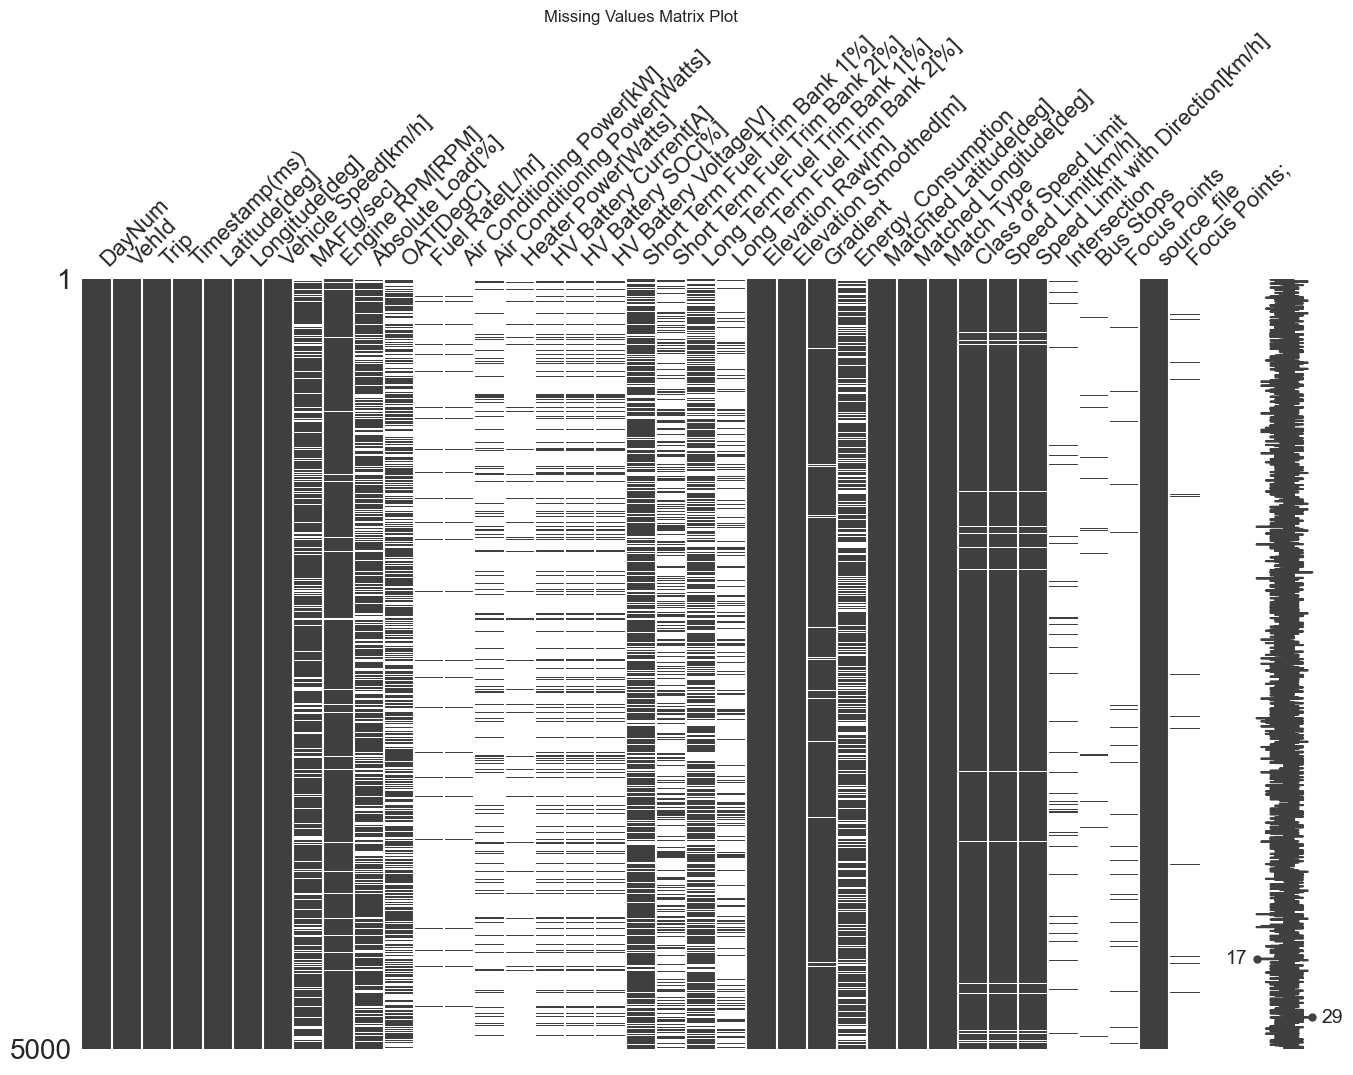

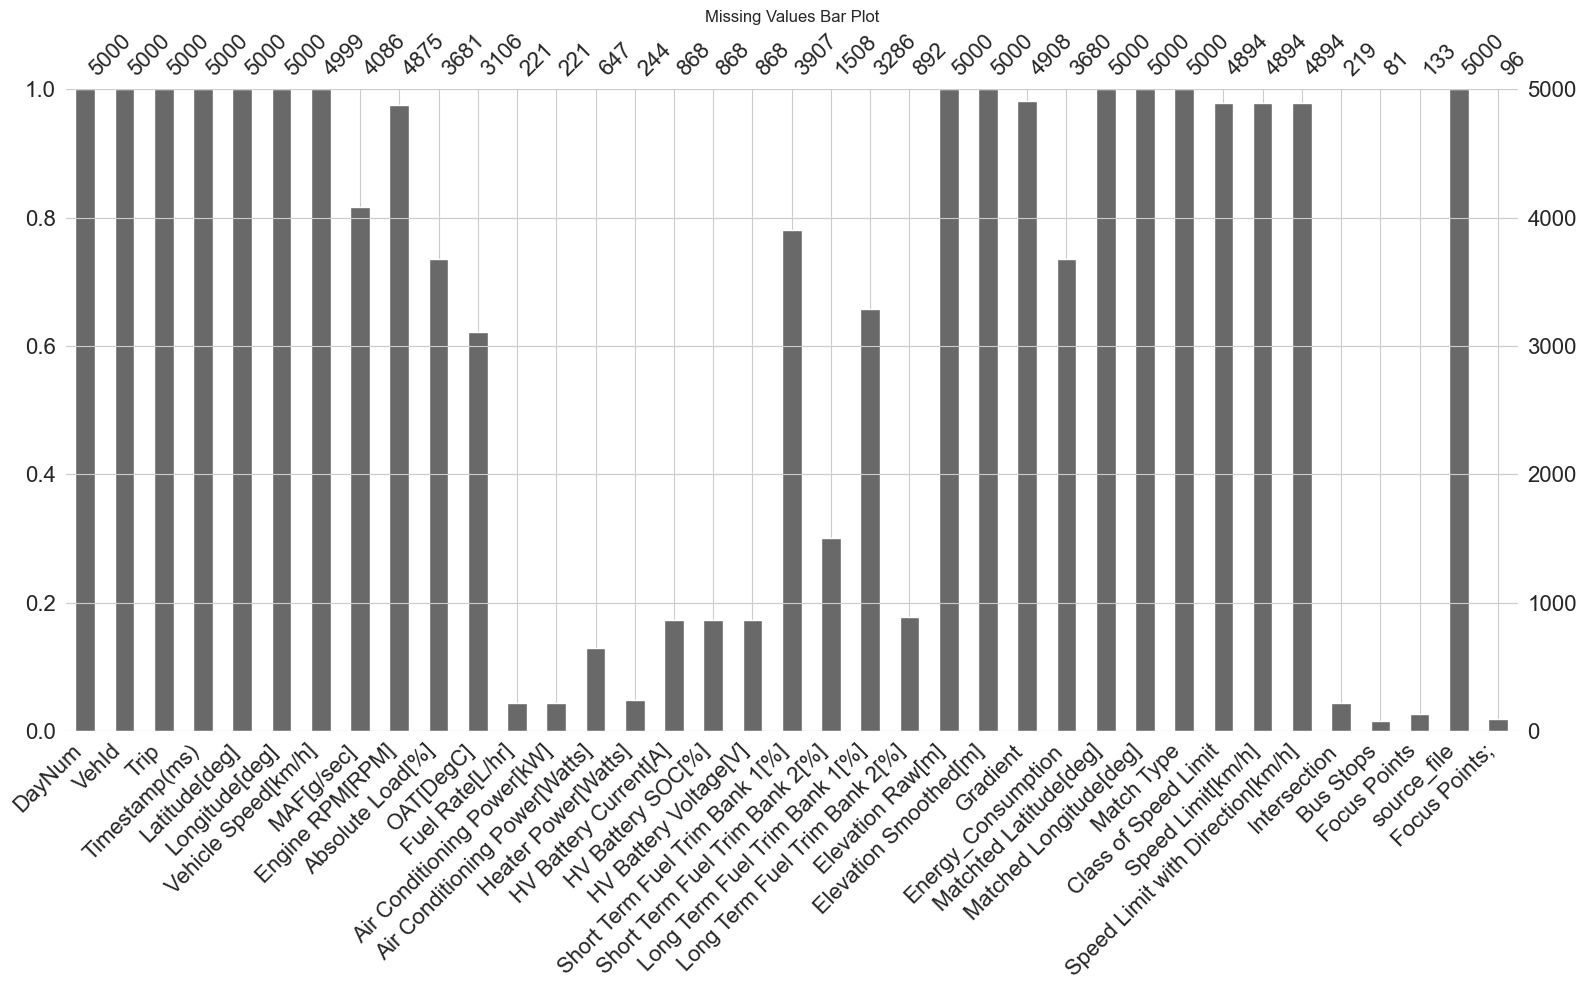

In [36]:
print("\n3.1 MISSING DATA VISUALIZATION")
print("-" * 40)

# Create a directory for visualizations if it doesn't exist
vis_dir = Path("~/Downloads/visualizations").expanduser()
if not vis_dir.exists():
    vis_dir.mkdir(parents=True)

# Matrix plot
plt.figure(figsize=(16, 10))
msno.matrix(ev_df.sample(min(5000, len(ev_df))), figsize=(16, 10))
plt.title('Missing Values Matrix Plot')
plt.tight_layout()
plt.savefig(vis_dir / 'missing_data_matrix.png')
plt.show()
plt.close()

# Bar plot
plt.figure(figsize=(16, 10))
msno.bar(ev_df.sample(min(5000, len(ev_df))), figsize=(16, 10))
plt.title('Missing Values Bar Plot')
plt.tight_layout()
plt.savefig(vis_dir / 'missing_data_bar.png')
plt.show()
plt.close()

There appears to generally be no patterns in the missing values. We can attempt to impute values and replace certain values with 0.

In [37]:
print("\n4. NUMERICAL STATISTICS")
print("-" * 40)
# Select only numerical columns for statistics
numerical_columns = ev_df.select_dtypes(include=[np.number]).columns
print(ev_df[numerical_columns].describe().T)


4. NUMERICAL STATISTICS
----------------------------------------
                                     count           mean            std  \
DayNum                            499986.0     189.843910     109.053622   
VehId                             499986.0     400.389679     143.784318   
Trip                              499986.0    1639.102877    1192.199510   
Timestamp(ms)                     499986.0  452557.569812  556538.286504   
Latitude[deg]                     499986.0      42.271819       0.021558   
Longitude[deg]                    499986.0     -83.728103       0.032499   
Vehicle Speed[km/h]               499953.0      40.595225      26.933102   
MAF[g/sec]                        405941.0       9.620877      10.323264   
Engine RPM[RPM]                   488880.0    1161.788414     759.500507   
Absolute Load[%]                  366474.0      29.544507      56.634169   
OAT[DegC]                         309391.0      14.836601      11.856344   
Fuel Rate[L/hr]       

In [38]:
# Create 'distributions' subdirectory only if it doesn't already exist
dist_dir = vis_dir / "distributions"
if not dist_dir.exists():
    dist_dir.mkdir()
    print(f"Created directory: {dist_dir}")
else:
    print(f"Directory already exists: {dist_dir}")

Directory already exists: /Users/vg/Downloads/visualizations/distributions


Created distribution plot for DayNum
Created distribution plot for VehId
Created distribution plot for Trip
Created distribution plot for Timestamp(ms)
Created distribution plot for Latitude[deg]
Created distribution plot for Longitude[deg]
Error creating plot for Vehicle Speed[km/h]: [Errno 2] No such file or directory: '/Users/vg/Downloads/visualizations/distributions/Vehicle Speed_km/h__dist.png'
Error creating plot for MAF[g/sec]: [Errno 2] No such file or directory: '/Users/vg/Downloads/visualizations/distributions/MAF_g/sec__dist.png'
Created distribution plot for Engine RPM[RPM]
Created distribution plot for Absolute Load[%]
Created distribution plot for OAT[DegC]
Error creating plot for Fuel Rate[L/hr]: [Errno 2] No such file or directory: '/Users/vg/Downloads/visualizations/distributions/Fuel Rate_L/hr__dist.png'
Created distribution plot for Air Conditioning Power[kW]
Created distribution plot for Air Conditioning Power[Watts]
Created distribution plot for Heater Power[Watts]

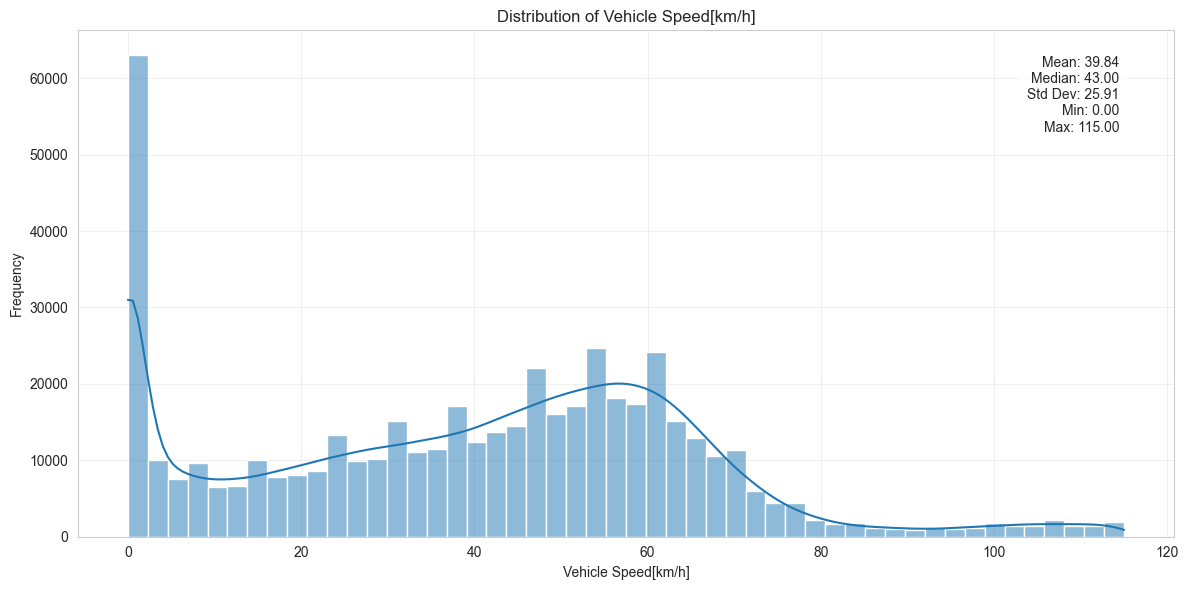

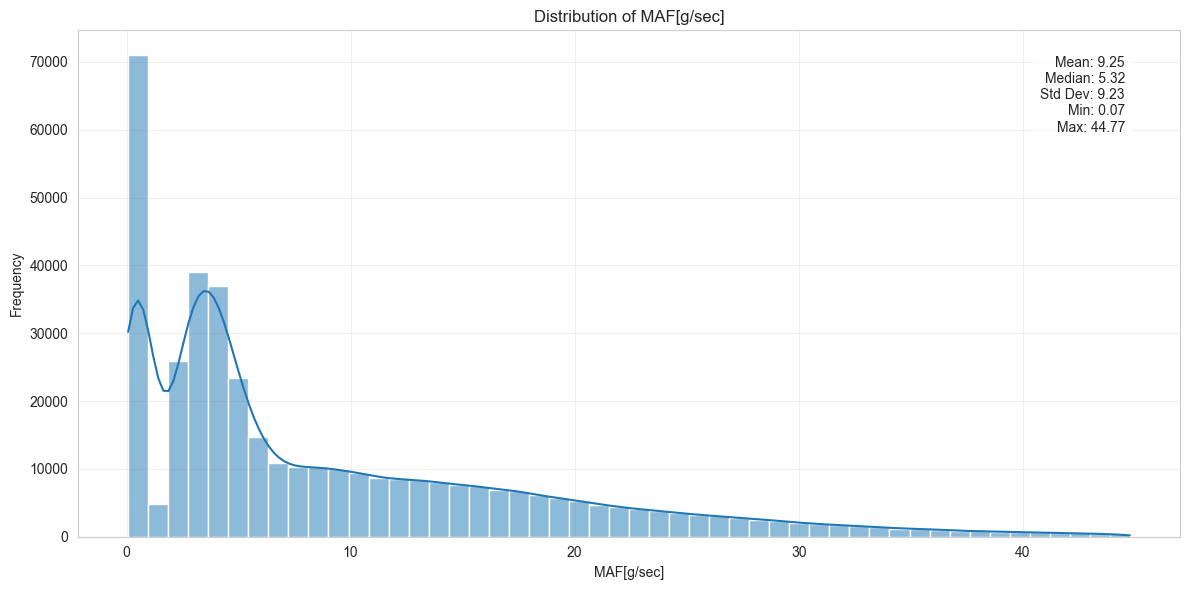

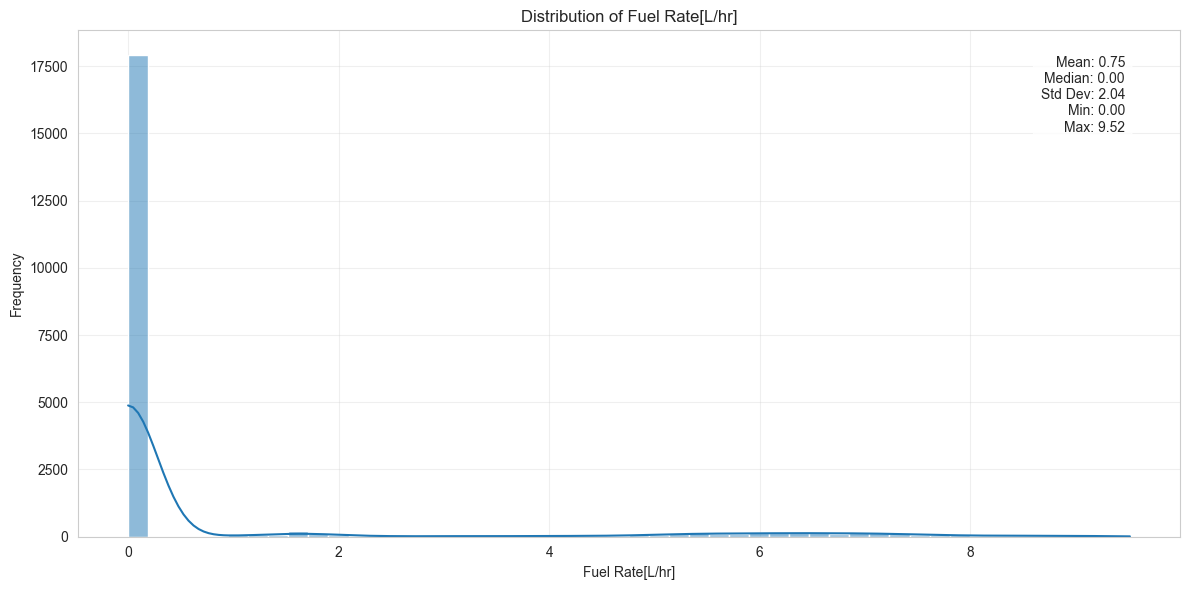

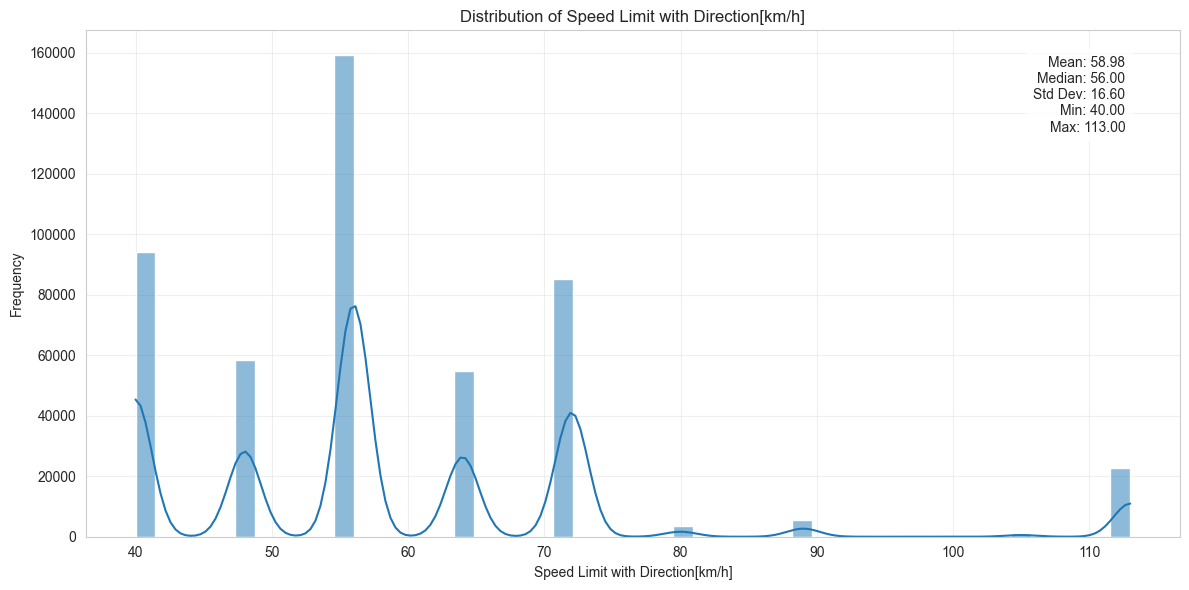

In [39]:
# Generate histograms for each numerical column
for col in numerical_columns:
    try:
        # Skip columns with all NaN values
        if ev_df[col].isna().all():
            continue
            
        plt.figure(figsize=(12, 6))
        
        # Filter out NaN values and clip to 1-99% to avoid extreme outliers
        data = ev_df[col].dropna()
        if len(data) > 0:
            lower_bound = data.quantile(0.01)
            upper_bound = data.quantile(0.99)
            filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]
            
            # Draw histogram and KDE
            sns.histplot(filtered_data, kde=True, bins=50)
            plt.title(f'Distribution of {col}')
            plt.xlabel(col)
            plt.ylabel('Frequency')
            plt.grid(True, alpha=0.3)
            
            # Add statistics annotation
            stats_text = (f"Mean: {filtered_data.mean():.2f}\n"
                        f"Median: {filtered_data.median():.2f}\n"
                        f"Std Dev: {filtered_data.std():.2f}\n"
                        f"Min: {filtered_data.min():.2f}\n"
                        f"Max: {filtered_data.max():.2f}")
            
            plt.annotate(stats_text, xy=(0.95, 0.95), xycoords='axes fraction',
                        bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8),
                        ha='right', va='top')
            
            plt.tight_layout()
            plt.savefig(dist_dir / f"{col.replace('[', '_').replace(']', '_')}_dist.png")
            plt.close()
            
            print(f"Created distribution plot for {col}")
    except Exception as e:
        print(f"Error creating plot for {col}: {e}")

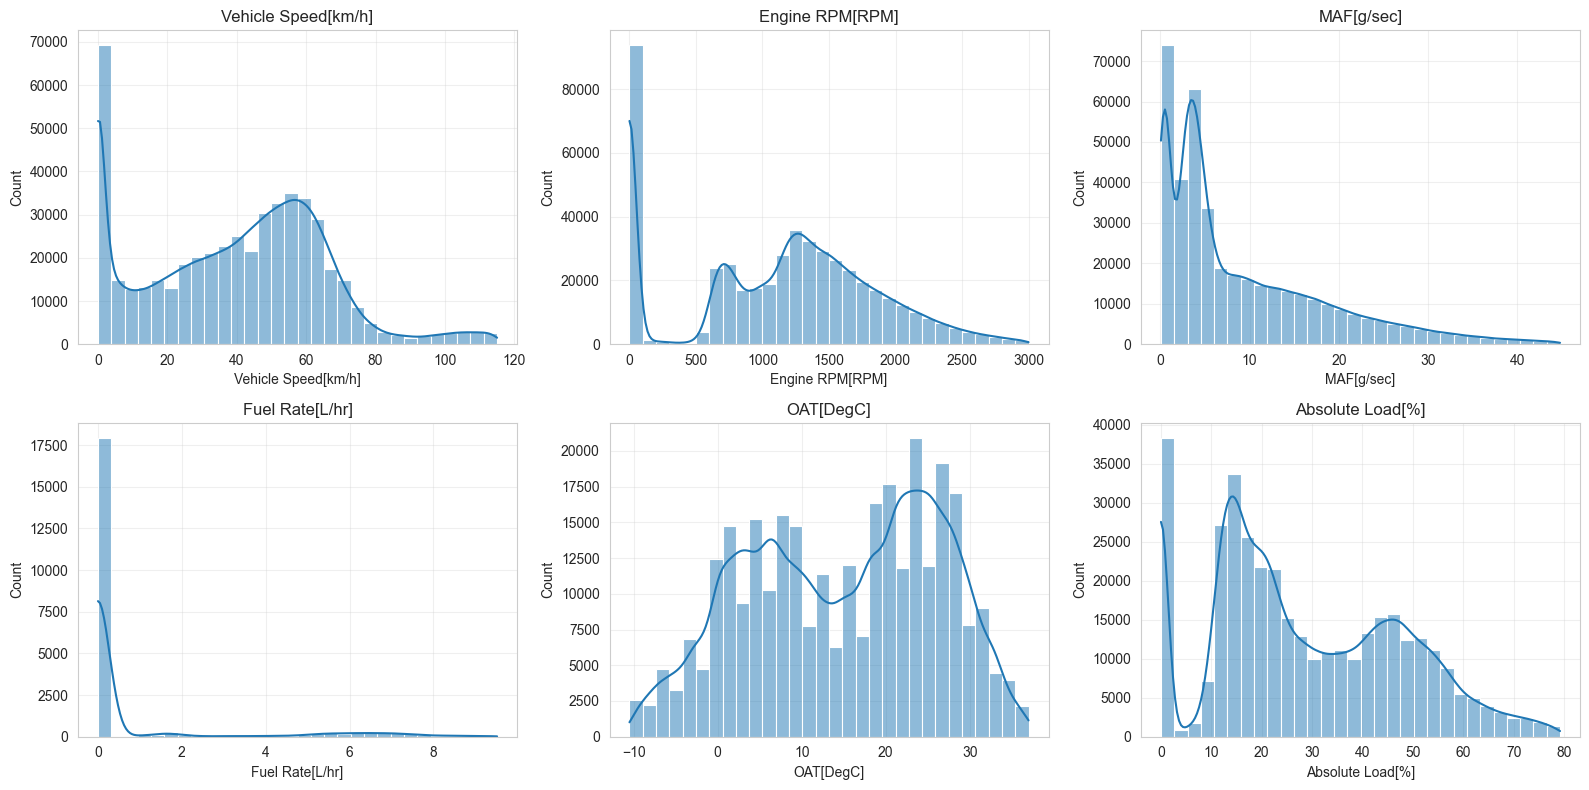

Created grid of key metrics distributions


In [40]:
# Create multi-histogram grid for key metrics
key_metrics = [
    'Vehicle Speed[km/h]', 
    'Engine RPM[RPM]', 
    'MAF[g/sec]', 
    'Fuel Rate[L/hr]', 
    'OAT[DegC]', 
    'Absolute Load[%]'
]

# Filter to only include columns that exist in the dataset
key_metrics = [col for col in key_metrics if col in ev_df.columns]

if key_metrics:
    # Determine grid size
    n_metrics = len(key_metrics)
    n_cols = min(3, n_metrics)
    n_rows = (n_metrics + n_cols - 1) // n_cols  # Ceiling division
    
    plt.figure(figsize=(16, 4*n_rows))
    
    for i, col in enumerate(key_metrics, 1):
        data = ev_df[col].dropna()
        if len(data) > 0:
            plt.subplot(n_rows, n_cols, i)
            
            # Filter outliers
            lower_bound = data.quantile(0.01)
            upper_bound = data.quantile(0.99)
            filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]
            
            # Plot histogram with KDE
            sns.histplot(filtered_data, kde=True, bins=30)
            plt.title(f'{col}')
            plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(vis_dir / 'key_metrics_distribution_grid.png')
    plt.show()
    plt.close()
    
    print("Created grid of key metrics distributions")

In [41]:
# Clean and preprocess data
ev_df_clean = ev_df.copy()

# Convert columns to appropriate types
cols_to_numeric = [
    'Latitude[deg]', 'Longitude[deg]', 'Vehicle Speed[km/h]', 
    'MAF[g/sec]', 'Engine RPM[RPM]', 'Absolute Load[%]',
    'OAT[DegC]', 'Fuel Rate[L/hr]', 'HV Battery SOC[%]',
    'HV Battery Current[A]', 'HV Battery Voltage[V]',
    'Speed Limit[km/h]'
]

for col in cols_to_numeric:
    if col in ev_df_clean.columns:
        ev_df_clean[col] = pd.to_numeric(ev_df_clean[col], errors='coerce')

# Filter out any rows with invalid coordinates
lat_col = 'Matched Latitude[deg]' if 'Matched Latitude[deg]' in ev_df_clean.columns else 'Latitude[deg]'
lon_col = 'Matched Longitude[deg]' if 'Matched Longitude[deg]' in ev_df_clean.columns else 'Longitude[deg]'

ev_df_clean = ev_df_clean[(ev_df_clean[lat_col].notna()) & (ev_df_clean[lon_col].notna())]
ev_df_clean = ev_df_clean[(ev_df_clean[lat_col] != 0) & (ev_df_clean[lon_col] != 0)]

# Calculate derived metrics
if 'Fuel Rate[L/hr]' in ev_df_clean.columns and 'Vehicle Speed[km/h]' in ev_df_clean.columns:
    # Avoid division by zero
    mask = ev_df_clean['Vehicle Speed[km/h]'] > 0
    ev_df_clean.loc[mask, 'Fuel Efficiency[L/100km]'] = (ev_df_clean.loc[mask, 'Fuel Rate[L/hr]'] * 100) / ev_df_clean.loc[mask, 'Vehicle Speed[km/h]']

# Sort by vehicle, trip, and timestamp
if all(col in ev_df_clean.columns for col in ['VehId', 'Trip', 'Timestamp(ms)']):
    ev_df_clean = ev_df_clean.sort_values(by=['VehId', 'Trip', 'Timestamp(ms)']).reset_index(drop=True)

print(f"\nCleaned data shape: {ev_df_clean.shape}")


Cleaned data shape: (499986, 38)



4.4 PAIRWISE RELATIONSHIPS
----------------------------------------


<Figure size 1200x1000 with 0 Axes>

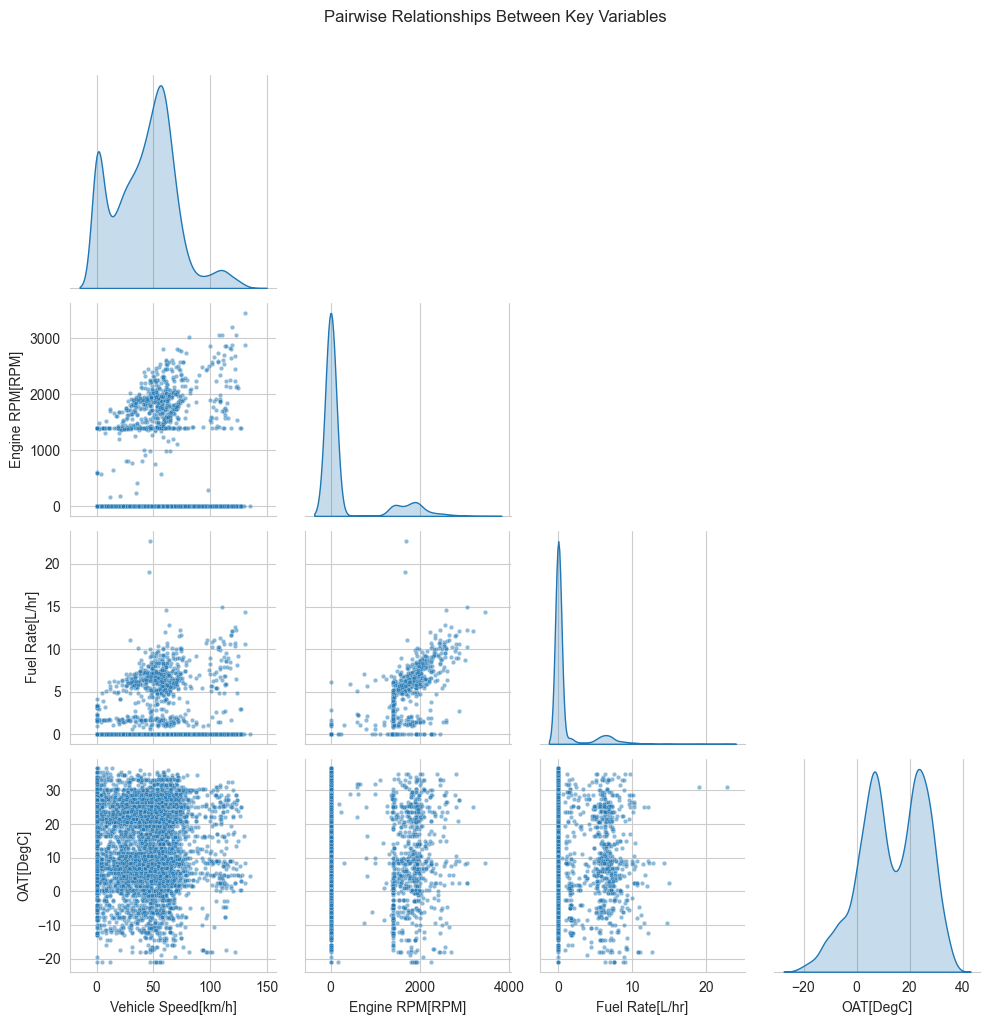

Created pairwise relationship plot


In [42]:
# NEW: Pairplot for key variables
print("\n4.4 PAIRWISE RELATIONSHIPS")
print("-" * 40)

# Create pairplot for key variables
pairplot_vars = [
    'Vehicle Speed[km/h]', 
    'Engine RPM[RPM]', 
    'Fuel Rate[L/hr]',
    'OAT[DegC]'
]

available_vars = [col for col in pairplot_vars if col in ev_df_clean.columns]

if len(available_vars) >= 2:
    try:
        # Sample data to keep pairplot manageable
        plot_sample = ev_df_clean[available_vars].dropna().sample(min(5000, len(ev_df_clean)))
        
        plt.figure(figsize=(12, 10))
        pair_g = sns.pairplot(
            plot_sample, 
            vars=available_vars,
            diag_kind='kde',
            plot_kws={'alpha': 0.5, 's': 10},
            corner=True  # Only show lower triangle
        )
        pair_g.fig.suptitle('Pairwise Relationships Between Key Variables', y=1.02)
        plt.tight_layout()
        plt.savefig(vis_dir / 'pairwise_relationships.png')
        plt.show()
        plt.close()
        
        print("Created pairwise relationship plot")
    except Exception as e:
        print(f"Error creating pairplot: {e}")

In [43]:
# 5. TRIP ANALYSIS
print("\n5. TRIP ANALYSIS")
print("-" * 40)

if 'VehId' in ev_df_clean.columns and 'Trip' in ev_df_clean.columns:
    # Count trips per vehicle
    trips_per_vehicle = ev_df_clean.groupby('VehId')['Trip'].nunique()
    print(f"Number of vehicles: {ev_df_clean['VehId'].nunique()}")
    print(f"Total trips: {ev_df_clean['Trip'].nunique()}")
    print(f"Average trips per vehicle: {trips_per_vehicle.mean():.2f}")
    
    # Trip duration and distance
    if 'Timestamp(ms)' in ev_df_clean.columns:
        trip_stats = ev_df_clean.groupby(['VehId', 'Trip']).agg({
            'Timestamp(ms)': lambda x: (max(x) - min(x)) / 1000 / 60  # Duration in minutes
        }).reset_index()
        
        print(f"\nTrip Duration Statistics (minutes):")
        print(trip_stats['Timestamp(ms)'].describe())
        
        # Plot distribution of trip durations
        plt.figure(figsize=(12, 6))
        sns.histplot(trip_stats['Timestamp(ms)'], bins=50, kde=True)
        plt.title('Distribution of Trip Durations')
        plt.xlabel('Duration (minutes)')
        plt.ylabel('Frequency')
        plt.xlim(0, trip_stats['Timestamp(ms)'].quantile(0.95))  # Limit to 95th percentile
        plt.savefig(vis_dir / 'trip_duration_dist.png')
        plt.close()
        
        print("\nTrip duration distribution plot saved in visualizations directory")

    # NEW: Trip count visualization
    plt.figure(figsize=(12, 6))
    sns.histplot(trips_per_vehicle, bins=30, kde=True)
    plt.title('Distribution of Trip Counts per Vehicle')
    plt.xlabel('Number of Trips')
    plt.ylabel('Number of Vehicles')
    plt.grid(True, alpha=0.3)
    plt.savefig(vis_dir / 'trips_per_vehicle_dist.png')
    plt.close()
    
    print("Created trip count per vehicle distribution plot")


5. TRIP ANALYSIS
----------------------------------------
Number of vehicles: 384
Total trips: 4150
Average trips per vehicle: 84.06

Trip Duration Statistics (minutes):
count    32278.000000
mean         7.851422
std          8.425496
min          0.000000
25%          2.511667
50%          5.805833
75%         10.395000
max        166.080000
Name: Timestamp(ms), dtype: float64

Trip duration distribution plot saved in visualizations directory
Created trip count per vehicle distribution plot



6. SPEED ANALYSIS
----------------------------------------
Speed Statistics:
count    499953.000000
mean         40.595225
std          26.933102
min           0.000000
25%          19.000000
50%          43.000000
75%          59.000000
max         165.000000
Name: Vehicle Speed[km/h], dtype: float64
Created speed distribution and boxplot visualizations

Speed Compliance Statistics (Speed/Limit):
count    431226.000000
mean          0.769237
std           0.340037
min           0.000139
25%           0.541667
50%           0.839286
75%           1.013889
max           5.000000
Name: Speed_Compliance, dtype: float64
Speed compliance distribution plot saved in visualizations directory


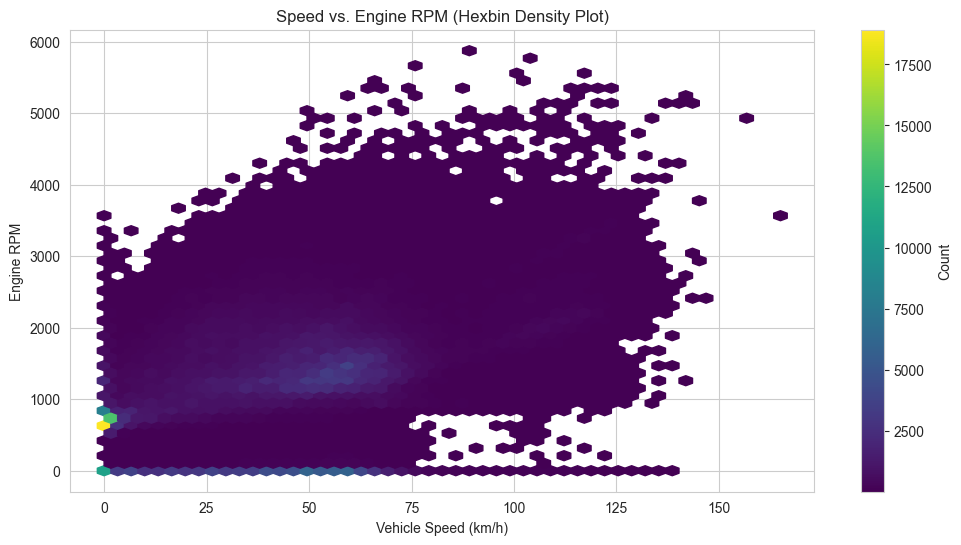

Created speed vs. RPM visualizations


In [44]:
# 6. SPEED ANALYSIS
print("\n6. SPEED ANALYSIS")
print("-" * 40)

if 'Vehicle Speed[km/h]' in ev_df_clean.columns:
    speed_data = ev_df_clean['Vehicle Speed[km/h]'].dropna()
    
    print(f"Speed Statistics:")
    print(speed_data.describe())
    
    # Plot speed distribution
    plt.figure(figsize=(12, 6))
    sns.histplot(speed_data, bins=50, kde=True)
    plt.title('Distribution of Vehicle Speeds')
    plt.xlabel('Speed (km/h)')
    plt.ylabel('Frequency')
    plt.savefig(vis_dir / 'speed_distribution.png')
    plt.close()
    
    # NEW: Speed boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(y=speed_data)
    plt.title('Box Plot of Vehicle Speeds')
    plt.ylabel('Speed (km/h)')
    plt.grid(True, axis='x')
    plt.savefig(vis_dir / 'speed_boxplot.png')
    plt.close()
    
    print("Created speed distribution and boxplot visualizations")
    
    # Speed vs speed limit compliance
    if 'Speed Limit[km/h]' in ev_df_clean.columns:
        df_with_limits = ev_df_clean[(ev_df_clean['Speed Limit[km/h]'] > 0) & (ev_df_clean['Vehicle Speed[km/h]'] > 0)]
        if len(df_with_limits) > 0:
            df_with_limits['Speed_Compliance'] = df_with_limits['Vehicle Speed[km/h]'] / df_with_limits['Speed Limit[km/h]']
            
            print(f"\nSpeed Compliance Statistics (Speed/Limit):")
            print(df_with_limits['Speed_Compliance'].describe())
            
            plt.figure(figsize=(12, 6))
            sns.histplot(df_with_limits['Speed_Compliance'].clip(0, 2), bins=50, kde=True)
            plt.axvline(x=1, color='r', linestyle='--')
            plt.title('Speed Compliance Ratio (Vehicle Speed / Speed Limit)')
            plt.xlabel('Compliance Ratio')
            plt.ylabel('Frequency')
            plt.savefig(vis_dir / 'speed_compliance.png')
            plt.close()
            
            print("Speed compliance distribution plot saved in visualizations directory")
    
    # Speed vs RPM if available
# Speed vs RPM if available
    if 'Engine RPM[RPM]' in ev_df_clean.columns:
        # Align the data by dropping rows where either Vehicle Speed or Engine RPM is NaN
        ev_df_clean_aligned = ev_df_clean.dropna(subset=['Vehicle Speed[km/h]', 'Engine RPM[RPM]'])
        
        # Scatter plot
        plt.figure(figsize=(12, 6))
        sns.scatterplot(data=ev_df_clean_aligned.sample(min(10000, len(ev_df_clean_aligned))), 
                       x='Vehicle Speed[km/h]', y='Engine RPM[RPM]',
                       alpha=0.5)
        plt.title('Speed vs. Engine RPM')
        plt.savefig(vis_dir / 'speed_vs_rpm.png')
        plt.close()
        
        # Hexbin plot for better density visualization
        plt.figure(figsize=(12, 6))
        plt.hexbin(
            ev_df_clean_aligned['Vehicle Speed[km/h]'],
            ev_df_clean_aligned['Engine RPM[RPM]'],
            gridsize=50, cmap='viridis', mincnt=1
        )
        plt.colorbar(label='Count')
        plt.title('Speed vs. Engine RPM (Hexbin Density Plot)')
        plt.xlabel('Vehicle Speed (km/h)')
        plt.ylabel('Engine RPM')
        plt.savefig(vis_dir / 'speed_vs_rpm_hexbin.png')
        plt.show()
        plt.close()
        
        print("Created speed vs. RPM visualizations")



7. ENERGY/FUEL ANALYSIS
----------------------------------------
Fuel Rate Statistics (L/hr):
count    21088.000000
mean         0.855384
std          2.298821
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         24.700001
Name: Fuel Rate[L/hr], dtype: float64


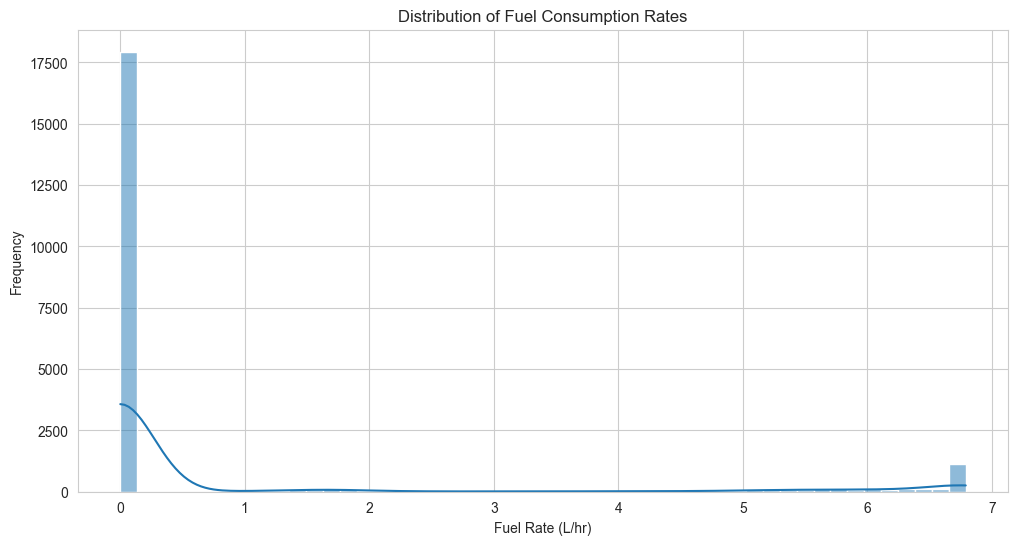

Fuel rate distribution plot saved in visualizations directory


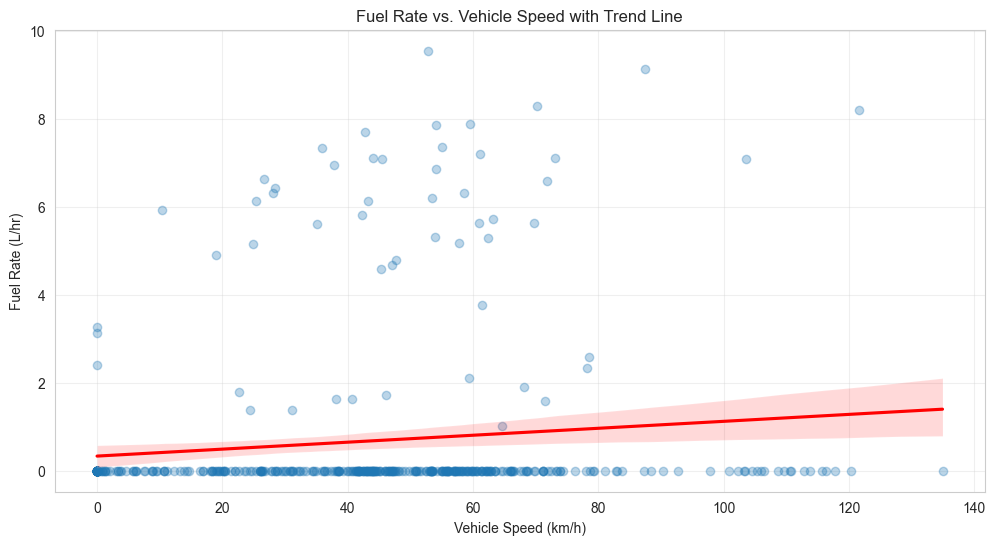

Created fuel rate vs. speed plot with trend line

Fuel Efficiency Statistics (L/100km):
count    18952.000000
mean         1.724907
std          4.562855
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         29.773776
Name: Fuel Efficiency[L/100km], dtype: float64


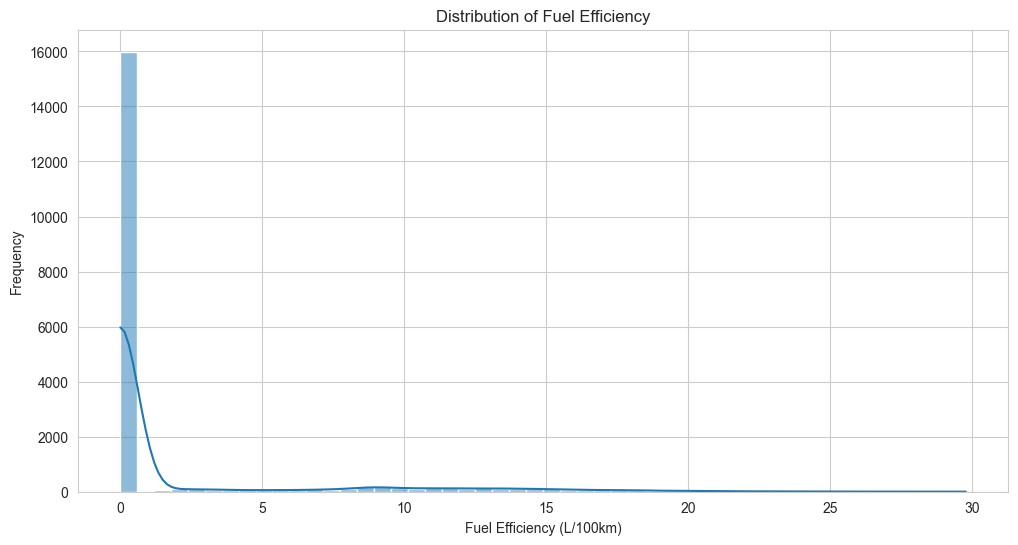

Fuel efficiency distribution plot saved in visualizations directory


In [45]:
# 7. ENERGY/FUEL ANALYSIS
print("\n7. ENERGY/FUEL ANALYSIS")
print("-" * 40)

if 'Fuel Rate[L/hr]' in ev_df_clean.columns:
    fuel_data = ev_df_clean['Fuel Rate[L/hr]'].dropna()
    
    print(f"Fuel Rate Statistics (L/hr):")
    print(fuel_data.describe())
    
    plt.figure(figsize=(12, 6))
    sns.histplot(fuel_data.clip(0, fuel_data.quantile(0.95)), bins=50, kde=True)
    plt.title('Distribution of Fuel Consumption Rates')
    plt.xlabel('Fuel Rate (L/hr)')
    plt.ylabel('Frequency')
    plt.savefig(vis_dir / 'fuel_rate_dist.png')
    plt.show()
    plt.close()
    
    print("Fuel rate distribution plot saved in visualizations directory")
    
    # NEW: Fuel rate vs. speed scatter plot with trend line
    plt.figure(figsize=(12, 6))
    sns.regplot(
        x='Vehicle Speed[km/h]', 
        y='Fuel Rate[L/hr]',
        data=ev_df_clean.sample(min(10000, len(ev_df_clean))),
        scatter_kws={'alpha': 0.3},
        line_kws={'color': 'red'}
    )
    plt.title('Fuel Rate vs. Vehicle Speed with Trend Line')
    plt.xlabel('Vehicle Speed (km/h)')
    plt.ylabel('Fuel Rate (L/hr)')
    plt.grid(True, alpha=0.3)
    plt.savefig(vis_dir / 'fuel_rate_vs_speed.png')
    plt.show()
    plt.close()
    
    print("Created fuel rate vs. speed plot with trend line")
    
if 'Fuel Efficiency[L/100km]' in ev_df_clean.columns:
    efficiency_data = ev_df_clean['Fuel Efficiency[L/100km]'].dropna()
    efficiency_data = efficiency_data[efficiency_data.between(0, 30)]  # Filter out unreasonable values
    
    print(f"\nFuel Efficiency Statistics (L/100km):")
    print(efficiency_data.describe())
    
    plt.figure(figsize=(12, 6))
    sns.histplot(efficiency_data, bins=50, kde=True)
    plt.title('Distribution of Fuel Efficiency')
    plt.xlabel('Fuel Efficiency (L/100km)')
    plt.ylabel('Frequency')
    plt.savefig(vis_dir / 'fuel_efficiency_dist.png')
    plt.show()
    plt.close()
    
    print("Fuel efficiency distribution plot saved in visualizations directory")


Battery State of Charge Statistics (%):
count    85199.000000
mean        38.184853
std         34.974245
min          0.000000
25%          0.784314
50%         35.294128
75%         70.588257
max        100.000031
Name: HV Battery SOC[%], dtype: float64


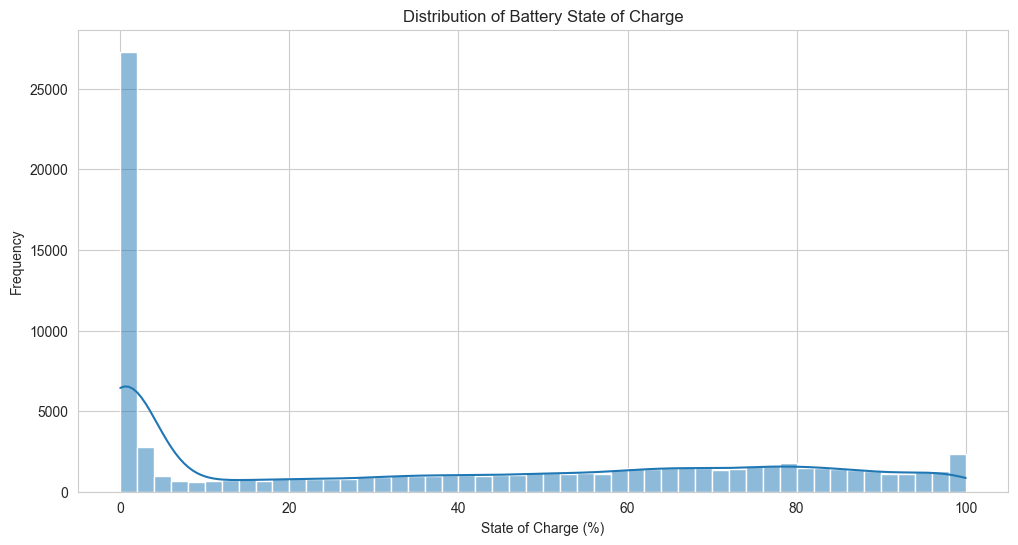

Battery SOC distribution plot saved in visualizations directory


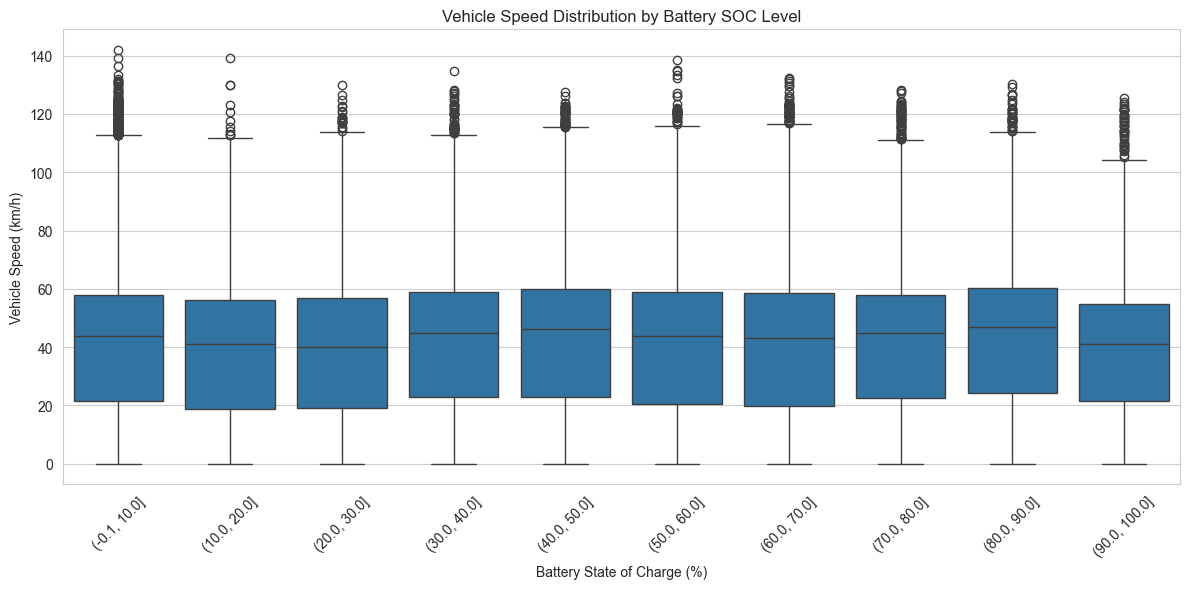

Created vehicle speed by battery SOC visualization


In [46]:
# Check for EV-specific metrics
if 'HV Battery SOC[%]' in ev_df_clean.columns:
    soc_data = ev_df_clean['HV Battery SOC[%]'].dropna()
    
    print(f"\nBattery State of Charge Statistics (%):")
    print(soc_data.describe())
    
    plt.figure(figsize=(12, 6))
    sns.histplot(soc_data, bins=50, kde=True)
    plt.title('Distribution of Battery State of Charge')
    plt.xlabel('State of Charge (%)')
    plt.ylabel('Frequency')
    plt.show()
    plt.savefig(vis_dir / 'battery_soc_dist.png')
    plt.close()
    
    print("Battery SOC distribution plot saved in visualizations directory")
    
    # NEW: Battery SOC vs Performance
    if 'Vehicle Speed[km/h]' in ev_df_clean.columns:
        plt.figure(figsize=(12, 6))
        
        # Create SOC bins for boxplot
        ev_df_clean['SOC_bin'] = pd.cut(ev_df_clean['HV Battery SOC[%]'], bins=10)
        
        sns.boxplot(x='SOC_bin', y='Vehicle Speed[km/h]', data=ev_df_clean)
        plt.title('Vehicle Speed Distribution by Battery SOC Level')
        plt.xlabel('Battery State of Charge (%)')
        plt.ylabel('Vehicle Speed (km/h)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(vis_dir / 'speed_by_soc.png')
        plt.show()
        plt.close()
        
        print("Created vehicle speed by battery SOC visualization")

In [47]:
import folium
from folium.plugins import HeatMap
import pandas as pd
from IPython.display import display
from pathlib import Path

# Assuming ev_df_clean is already loaded and cleaned

print("\n8. GEOGRAPHICAL ANALYSIS")
print("-" * 40)

# Set up directory to save visualizations
vis_dir = Path("~/Downloads/visualizations").expanduser()
vis_dir.mkdir(parents=True, exist_ok=True)

# Determine latitude and longitude columns
lat_col = 'Matched Latitude[deg]' if 'Matched Latitude[deg]' in ev_df_clean.columns else 'Latitude[deg]'
lon_col = 'Matched Longitude[deg]' if 'Matched Longitude[deg]' in ev_df_clean.columns else 'Longitude[deg]'

# Check if both columns exist
if lat_col in ev_df_clean.columns and lon_col in ev_df_clean.columns:
    # Sample data for visualization
    max_points = 10000
    geo_sample = ev_df_clean.sample(min(max_points, len(ev_df_clean)))

    # Calculate center of the map
    center_lat = geo_sample[lat_col].mean()
    center_lon = geo_sample[lon_col].mean()

    # Create base heatmap
    m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

    if len(geo_sample) > 0:
        print(f"Creating heatmap with {len(geo_sample)} data points...")
        heat_data = [[row[lat_col], row[lon_col]] for _, row in geo_sample.iterrows()]
        HeatMap(heat_data).add_to(m)

        # Save heatmap to file
        heatmap_file = vis_dir / 'vehicle_heatmap.html'
        m.save(str(heatmap_file))
        print(f"Heatmap saved to: {heatmap_file}")

        # Display heatmap in notebook
        display(m)

    # Create speed map if speed data is available
    if 'Vehicle Speed[km/h]' in ev_df_clean.columns:
        speed_map = folium.Map(location=[center_lat, center_lon], zoom_start=12)

        speed_sample = ev_df_clean.sample(min(2000, len(ev_df_clean)))

        for _, row in speed_sample.iterrows():
            if pd.notna(row[lat_col]) and pd.notna(row[lon_col]) and pd.notna(row['Vehicle Speed[km/h]']):
                speed = row['Vehicle Speed[km/h]']
                color = 'green' if speed < 30 else 'orange' if speed < 60 else 'red'

                folium.CircleMarker(
                    location=[row[lat_col], row[lon_col]],
                    radius=3,
                    color=color,
                    fill=True,
                    fill_opacity=0.7,
                    popup=f"Speed: {speed:.1f} km/h"
                ).add_to(speed_map)

        # Save speed map to file
        speed_map_file = vis_dir / 'vehicle_speed_map.html'
        speed_map.save(str(speed_map_file))
        print(f"Speed map saved to: {speed_map_file}")

        # Display speed map in notebook
        display(speed_map)

else:
    print("Latitude and Longitude columns not found in the dataset.")


8. GEOGRAPHICAL ANALYSIS
----------------------------------------
Creating heatmap with 10000 data points...
Heatmap saved to: /Users/vg/Downloads/visualizations/vehicle_heatmap.html


Speed map saved to: /Users/vg/Downloads/visualizations/vehicle_speed_map.html


In [51]:
df = ev_df_clean

In [52]:
# 2. Missing values check (to verify cleanup was successful)
missing_data = df.isnull().sum()
print("\nMissing values per column:")
print(missing_data[missing_data > 0])


Missing values per column:
Vehicle Speed[km/h]                     33
MAF[g/sec]                           94045
Engine RPM[RPM]                      11106
Absolute Load[%]                    133512
OAT[DegC]                           190595
Fuel Rate[L/hr]                     478898
Air Conditioning Power[kW]          478947
Air Conditioning Power[Watts]       435826
Heater Power[Watts]                 478454
HV Battery Current[A]               414787
HV Battery SOC[%]                   414787
HV Battery Voltage[V]               414787
Short Term Fuel Trim Bank 1[%]      108696
Short Term Fuel Trim Bank 2[%]      348157
Long Term Fuel Trim Bank 1[%]       168921
Long Term Fuel Trim Bank 2[%]       407752
Gradient                              9914
Energy_Consumption                  134328
Class of Speed Limit                 11610
Speed Limit[km/h]                    14439
Speed Limit with Direction[km/h]     11610
Intersection                        477459
Bus Stops                 

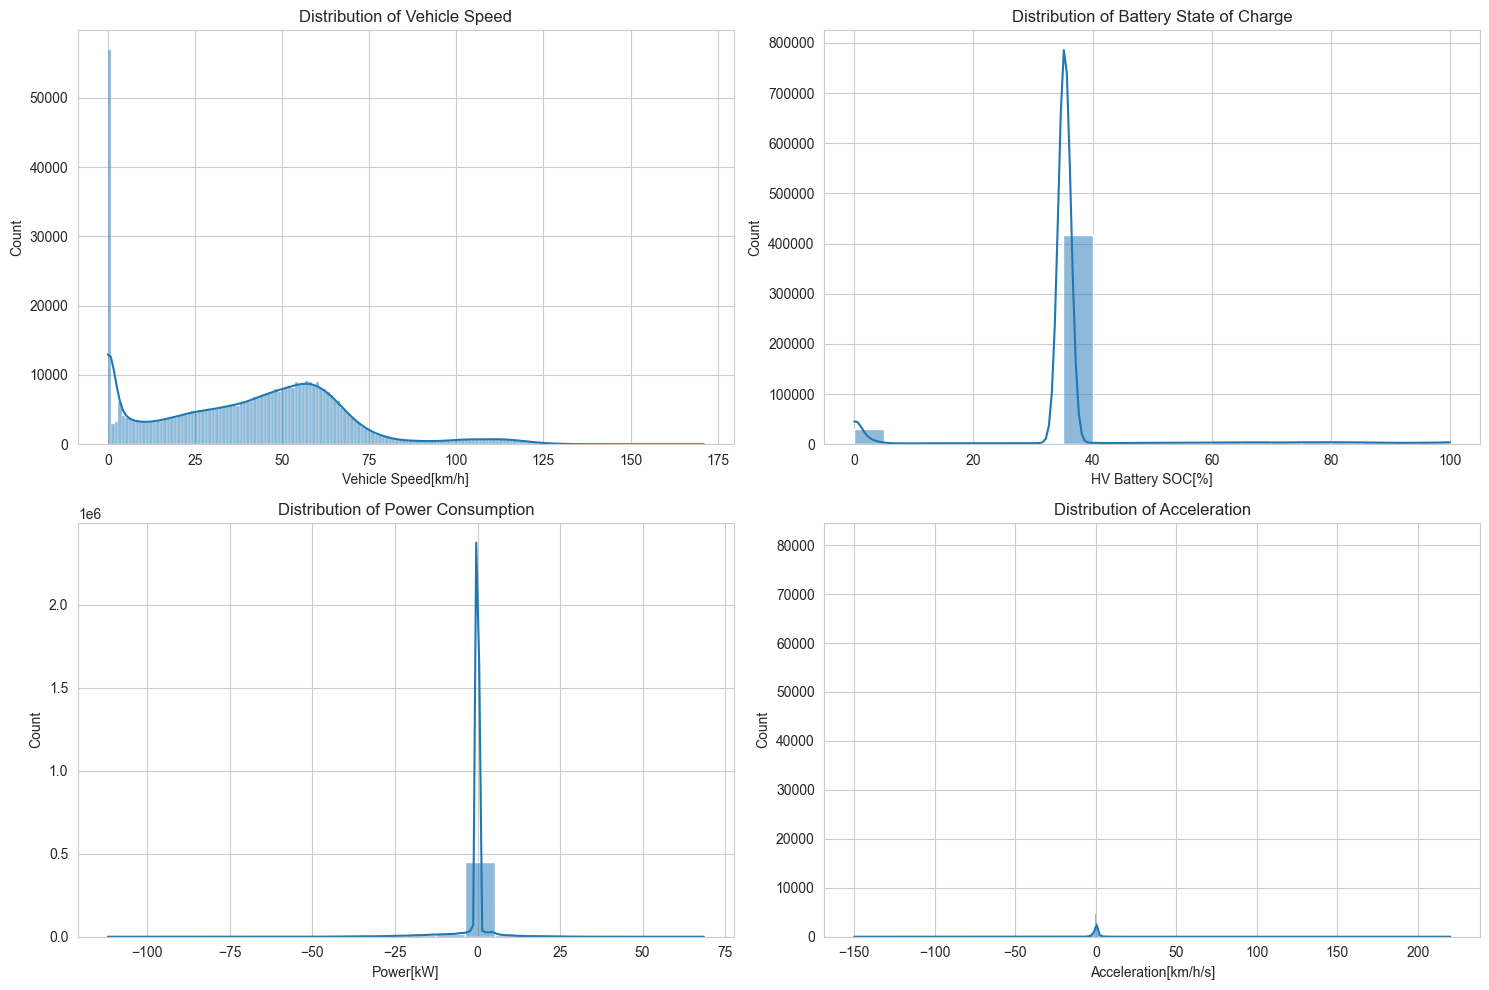

In [65]:
# 3. Distribution plots for key metrics
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.histplot(df['Vehicle Speed[km/h]'], kde=True)
plt.title('Distribution of Vehicle Speed')

plt.subplot(2, 2, 2)
if 'HV Battery SOC[%]' in df.columns:
    sns.histplot(df['HV Battery SOC[%]'], kde=True)
    plt.title('Distribution of Battery State of Charge')

plt.subplot(2, 2, 3)
if 'Power[kW]' in df.columns:
    sns.histplot(df['Power[kW]'], kde=True)
    plt.title('Distribution of Power Consumption')

plt.subplot(2, 2, 4)
if 'Acceleration[km/h/s]' in df.columns:
    sns.histplot(df['Acceleration[km/h/s]'], kde=True)
    plt.title('Distribution of Acceleration')

plt.tight_layout()
plt.savefig('distribution_plots.png')
plt.show()
plt.close()


Trip statistics:
       Timestamp(ms)_min  Timestamp(ms)_max  Timestamp(ms)_count  \
count       3.227700e+04       3.227700e+04         32277.000000   
mean        3.294075e+04       5.044055e+05            15.489791   
std         4.334953e+04       5.050933e+05            14.497142   
min        -1.655000e+06      -5.040000e+04             1.000000   
25%         7.900000e+03       1.848000e+05             6.000000   
50%         2.040000e+04       3.811000e+05            12.000000   
75%         4.410000e+04       6.556000e+05            20.000000   
max         1.987000e+06       9.990700e+06           257.000000   

       Vehicle Speed[km/h]_mean  Vehicle Speed[km/h]_max  \
count              32277.000000             32277.000000   
mean                  41.852416                67.079794   
std                   15.807727                19.262210   
min                    0.000000                 0.000000   
25%                   31.846154                58.000000   
50%      

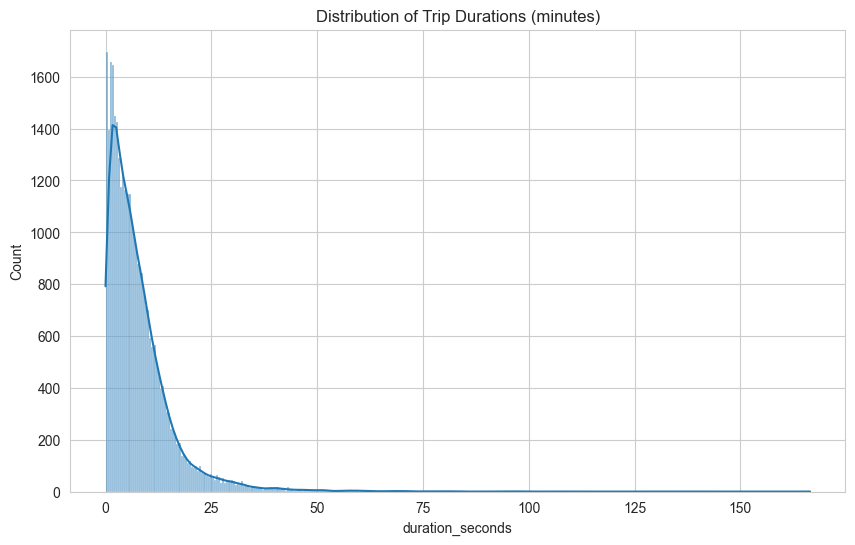

In [66]:
# 4. Trip analysis
if all(col in df.columns for col in ['VehId', 'Trip']):
    trip_stats = df.groupby(['VehId', 'Trip']).agg({
        'Timestamp(ms)': ['min', 'max', 'count'],
        'Vehicle Speed[km/h]': ['mean', 'max', 'std'],
        'step_id': 'count'
    })
    
    trip_stats.columns = ['_'.join(col).strip() for col in trip_stats.columns.values]
    trip_stats['duration_seconds'] = (trip_stats['Timestamp(ms)_max'] - trip_stats['Timestamp(ms)_min']) / 1000
    
    print("\nTrip statistics:")
    print(trip_stats.describe())
    
    # Plot trip durations
    plt.figure(figsize=(10, 6))
    sns.histplot(trip_stats['duration_seconds'] / 60, kde=True)  # Convert to minutes
    plt.title('Distribution of Trip Durations (minutes)')
    plt.savefig('trip_durations.png')
    plt.show()
    plt.close()

In [46]:
print("\n12. SUMMARY OF FINDINGS")
print("-" * 40)

print("Key insights from the exploratory data analysis:")
print("1. The dataset contains vehicle telemetry data from multiple vehicles and trips")
print("2. Data includes speed, engine parameters, fuel consumption, and geographical information")
print("3. Visualizations for speed profiles, fuel/energy consumption, and geographical patterns have been created")
print("4. Correlation analysis shows relationships between vehicle parameters")
print("5. Time-series analysis of a sample trip reveals driving patterns")
print("6. Environmental factors such as temperature may impact vehicle performance")
print("\nAll visualization files have been saved in the current directory.")

print("\nExploratory Data Analysis completed successfully!")


12. SUMMARY OF FINDINGS
----------------------------------------
Key insights from the exploratory data analysis:
1. The dataset contains vehicle telemetry data from multiple vehicles and trips
2. Data includes speed, engine parameters, fuel consumption, and geographical information
3. Visualizations for speed profiles, fuel/energy consumption, and geographical patterns have been created
4. Correlation analysis shows relationships between vehicle parameters
5. Time-series analysis of a sample trip reveals driving patterns
6. Environmental factors such as temperature may impact vehicle performance

All visualization files have been saved in the current directory.

Exploratory Data Analysis completed successfully!
